In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs

import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
#Load Dataset
EMBEDDING_FILE = '/content/drive/My Drive/Toxic/glove.840B.300d.txt'
train = pd.read_csv("/content/drive/My Drive/Toxic/train.csv")
test = pd.read_csv("/content/drive/My Drive/Toxic/test.csv")
test_labels = pd.read_csv("/content/drive/My Drive/Toxic/test_labels.csv")
test = test.merge(test_labels, on="id")
labels = list(train.columns[2:])

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train[target_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

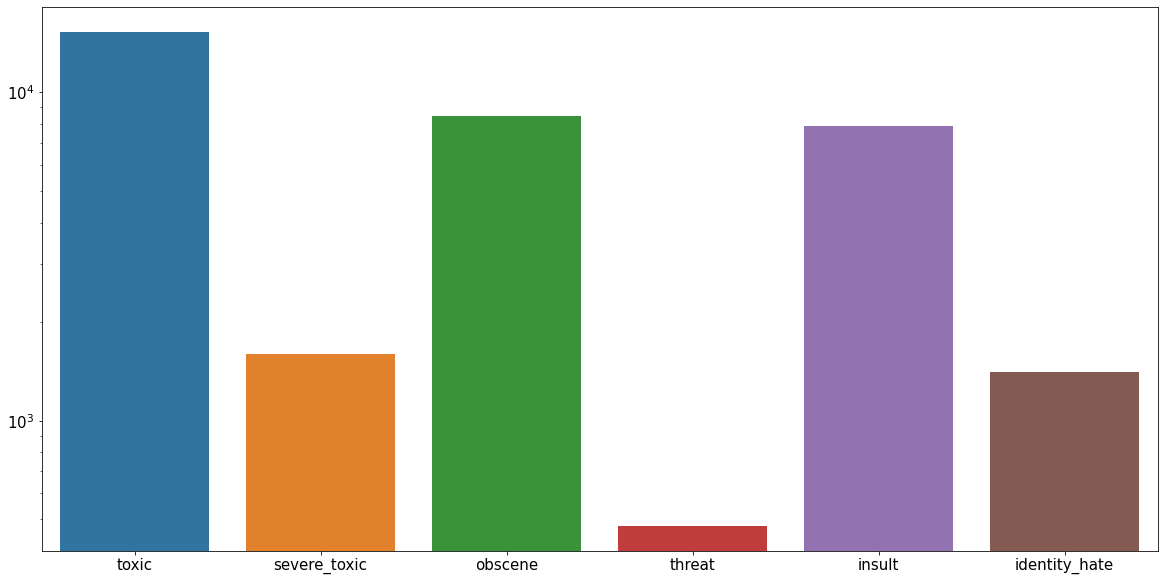

In [ ]:
analysis_columns = target_columns
label_counts = train[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


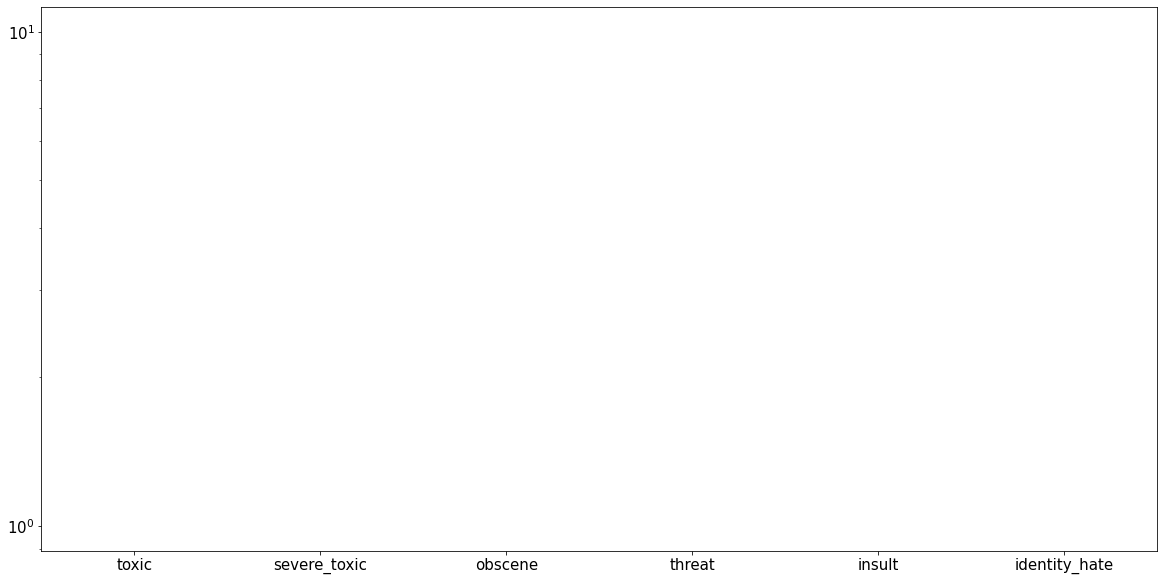

In [ ]:
analysis_columns = target_columns
label_counts = test[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

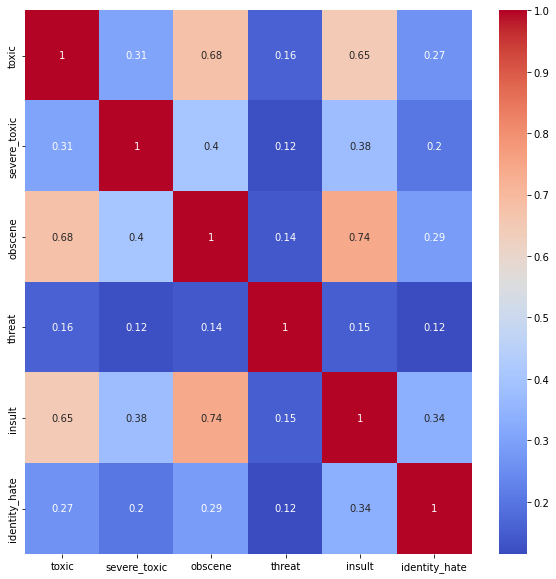

In [ ]:
#Corelation Matrix
heatmap_data = train[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

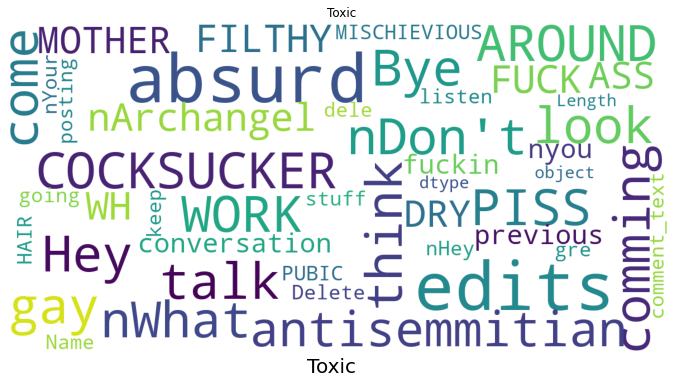

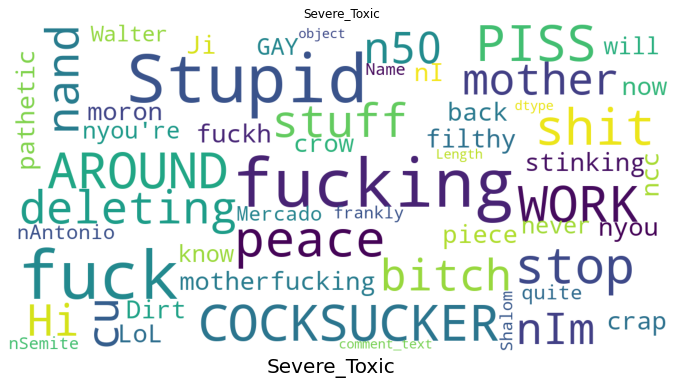

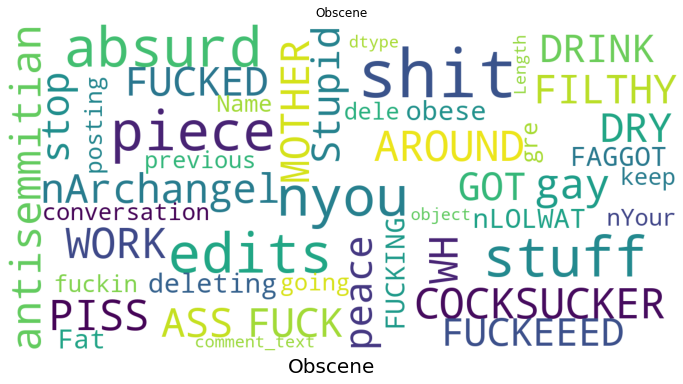

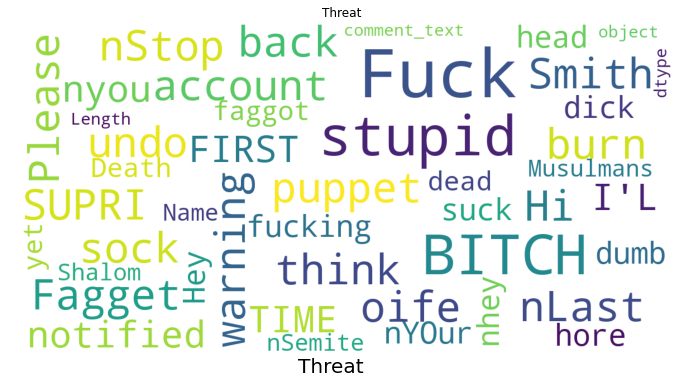

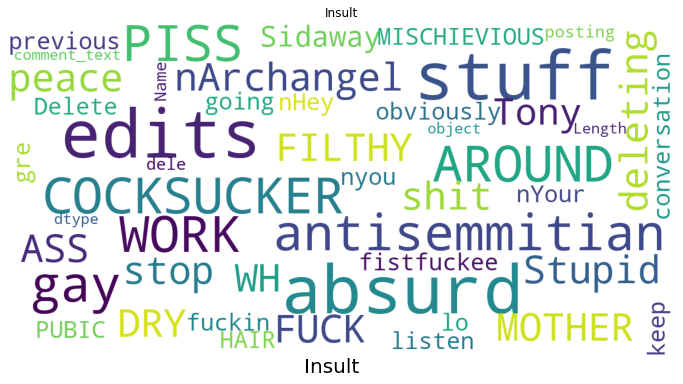

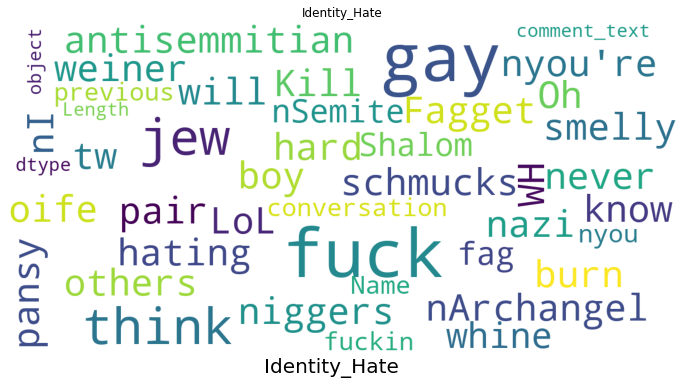

In [ ]:
#--- WordCloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
  wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=200, max_font_size=40, scale=3, random_state=1).generate(str(data)) # chosen at random by flipping a coin; it was heads
  fig = plt.figure(1, figsize=(12, 10))
  plt.axis('off')
  if title: 
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
  plt.title(title)
  plt.imshow(wordcloud)
  plt.show()

data = train[train.toxic == 1.0]
show_wordcloud(data['comment_text'],"Toxic")

data = train[train.severe_toxic == 1.0]
show_wordcloud(data['comment_text'],"Severe_Toxic")

data = train[train.obscene == 1.0]
show_wordcloud(data['comment_text'],"Obscene")

data = train[train.threat == 1.0]
show_wordcloud(data['comment_text'],"Threat")

data = train[train.insult == 1.0]
show_wordcloud(data['comment_text'],"Insult")

data = train[train.identity_hate == 1.0]
show_wordcloud(data['comment_text'],"Identity_Hate")


In [ ]:
# Drop all rows with -1 in label values
drop_idxs = test[
    (test.toxic == -1) | (test.severe_toxic == -1) | (test.obscene == -1) | 
    (test.threat == -1) | (test.insult == -1) | (test.identity_hate == -1)
].index
test = test.drop(drop_idxs, axis="rows")

In [ ]:
#Split Dataset
train["comment_text"].fillna("fillna")
test["comment_text"].fillna("fillna")
X_train = train["comment_text"].str.lower()
#y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].str.lower()
y_train = train[labels].values
y_test = test[labels].values

In [ ]:
max_features=100000
maxlen=150
embed_size=300
num_filters = 64
weight_decay = 1e-4

In [ ]:
#Word To vector conversion
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)


embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs



word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [ ]:
train['doc_len'] = train['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sequence_input = Input(shape=(maxlen, ))

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))


In [ ]:
#CNN 
batch_size = 128
epochs = 4
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=233)

model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(6, activation='sigmoid'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


filepath="/content/drive/My Drive/Toxic/CNN_Models/cnn_weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]
history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/4
1122/1122 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9039
 ROC-AUC - epoch: 1 - score: 0.974969
1122/1122 [==============================] - 25s 10ms/step - loss: 0.0759 - accuracy: 0.9039 - val_loss: 0.0531 - val_accuracy: 0.9823
Epoch 2/4
1118/1122 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9827
 ROC-AUC - epoch: 2 - score: 0.977207
1122/1122 [==============================] - 11s 9ms/step - loss: 0.0535 - accuracy: 0.9827 - val_loss: 0.0523 - val_accuracy: 0.9885
Epoch 3/4
1120/1122 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9910
 ROC-AUC - epoch: 3 - score: 0.980026
1122/1122 [==============================] - 11s 10ms/step - loss: 0.0482 - accuracy: 0.9910 - val_loss: 0.0489 - val_accuracy: 0.9930
Epoch 4/4
1122/1122 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9919
 ROC-AUC - epoch: 4 - score: 0.980389
1122/1122 [==============================] - 10s 9ms/ste

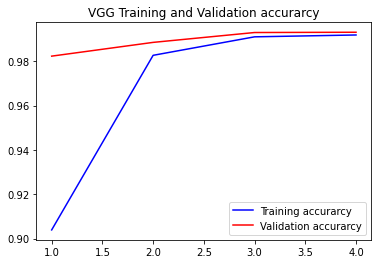

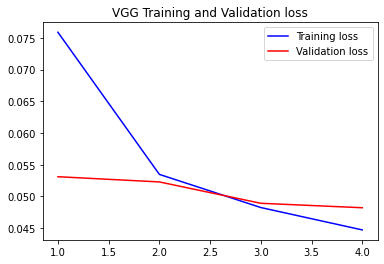

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('VGG Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('VGG Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x_test, batch_size=1024, verbose=1)

63/63 [==============================] - 1s 15ms/step


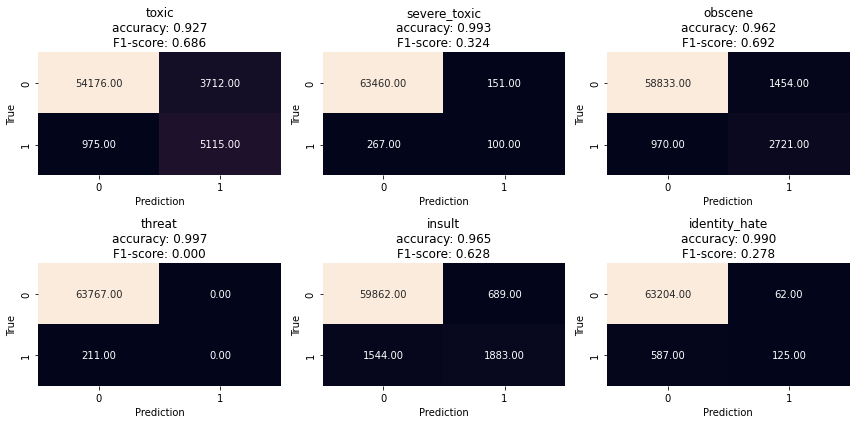

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
tests = pd.DataFrame(y_test, columns=labels)
preds = pd.DataFrame(y_pred, columns=labels).round() 

acc_dict = {}
f1s_dict = {}
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
for col, ax in zip(labels, axes.flatten()):
    true_label = tests[col]
    prediction = preds[col]
    # Record accuracy and F1 score
    acc = acc_dict[col] = accuracy_score(true_label, prediction)
    f1 = f1s_dict[col] = f1_score(true_label, prediction)
    # Confusion matrix
    (tn, fp), (fn, tp) = conf_matt = confusion_matrix(true_label, prediction)
    sns.heatmap(conf_matt, annot=True, cbar=False, fmt=".2f", ax=ax)
    ax.set_title(f"{col}\naccuracy: {acc:.3f}\nF1-score: {f1:.3f}")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
#Bidirectional LSTM
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=233)
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(6, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
filepath="/content/drive/My Drive/Toxic/LSTM_Models/weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]
history = model.fit(X_tra, y_tra, batch_size=128, epochs=4, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1122/1122 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9194
 ROC-AUC - epoch: 1 - score: 0.986840
1122/1122 [==============================] - 1199s 1s/step - loss: 0.0551 - accuracy: 0.9194 - val_loss: 0.0445 - val_accuracy: 0.9752
Epoch 2/4
1122/1122 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9418
 ROC-AUC - epoch: 2 - score: 0.988346
1122/1122 [==============================] - 1181s 1s/step - loss: 0.0439 - accuracy: 0.9418 - val_loss: 0.0423 - val_accuracy: 0.9623
Epoch 3/4
1122/1122 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9422
 ROC-AUC - epoch: 3 - score: 0.988737
1122/1122 [==============================] - 1146s 1s/step - loss: 0.0408 - accuracy: 0.9422 - val_loss: 0.0420 - val_accuracy: 0.9797
Epoch 4/4
1122/1122 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9312
 ROC-AUC - epoch: 4 - score: 0.988937
1122/1122 [==============================] - 1151s 1s/step - loss

In [ ]:
model.save('/content/drive/My Drive/Toxic/LSTM_Models/lstm_model.h5')

In [ ]:
import tensorflow
model = tensorflow.keras.models.load_model('/content/drive/My Drive/Toxic/LSTM_Models/lstm_model.h5')

In [ ]:
print(tensorflow.__version__)

2.8.2


In [ ]:
y_pred = model.predict(x_test, batch_size=1024, verbose=1)

63/63 [==============================] - 7s 106ms/step


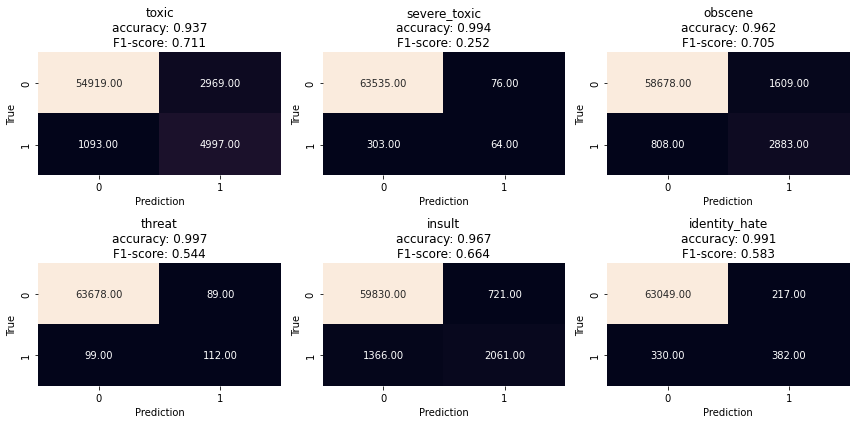

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
tests = pd.DataFrame(y_test, columns=labels)
preds = pd.DataFrame(y_pred, columns=labels).round() 

acc_dict = {}
f1s_dict = {}
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
for col, ax in zip(labels, axes.flatten()):
    true_label = tests[col]
    #print(true_label)
    prediction = preds[col]
    # Record accuracy and F1 score
    acc = acc_dict[col] = accuracy_score(true_label, prediction)
    f1 = f1s_dict[col] = f1_score(true_label, prediction)
    # Confusion matrix
    (tn, fp), (fn, tp) = conf_matt = confusion_matrix(true_label, prediction)
    sns.heatmap(conf_matt, annot=True, cbar=False, fmt=".2f", ax=ax)
    ax.set_title(f"{col}\naccuracy: {acc:.3f}\nF1-score: {f1:.3f}")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

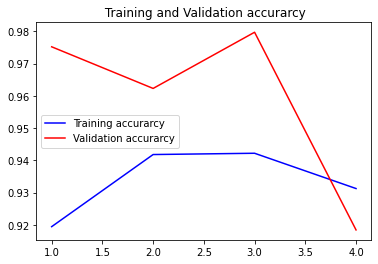

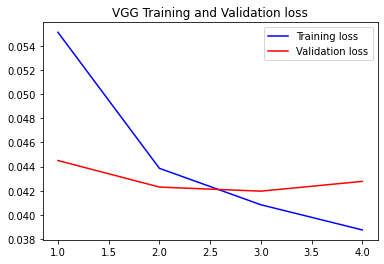

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title(' Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('VGG Training and Validation loss')
plt.legend()
plt.show()

[[0.9665142  0.2356749  0.82971156 0.39725807 0.7321226  0.93527377]]


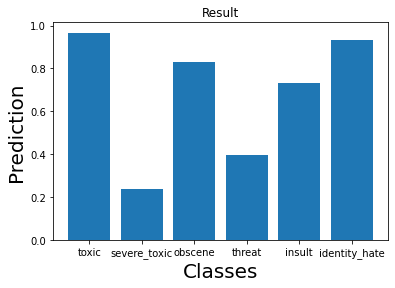

In [ ]:
def click():
		    import os
		    text="kill Niggas"
		    l=[]
		    l.append(text)
		    l=tok.texts_to_sequences(l)
		    l=sequence.pad_sequences(l,maxlen=maxlen)
		    #print(titleFeatures.shape)
		    prediction= model.predict(l)
		    print(prediction)
		    labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
		    sizes = [prediction[0][0],prediction[0][1],prediction[0][2],prediction[0][3],prediction[0][4],prediction[0][5]]
		    index = np.arange(len(labels))
		    plt.bar(index, sizes)
		    plt.xlabel('Classes', fontsize=20)
		    plt.ylabel('Prediction', fontsize=20)
		    plt.xticks(index, labels, fontsize=10, rotation=0)
		    plt.title('Result')
		    plt.show()
      
click()